# Conditional TimeGrad Demo

This notebook is a reproducible, end-to-end walkthrough of the conditional TimeGrad pipeline:

1. Load and preprocess the parquet datasets.
2. Inspect processed features for targets, dynamic, and static conditioning signals.
3. Build the conditioning-aware TimeGrad training and prediction networks.
4. Train for a few quick epochs (demo-friendly) with causal cross-attention and FiLM conditioning enabled.
5. Generate hundreds of scenario samples autoregressively.
6. Visualize raw prices, forecast mean/quantiles, individual scenario paths, and compare to ground truth.
7. Compute CRPS, MAE, and coverage metrics while highlighting conditioning effects.


In [2]:
# Imports + Config
import math
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

current_dir = Path.cwd().resolve()
project_root = None

# Check current directory and all parents
for parent in [current_dir] + list(current_dir.parents):
    if (parent / "src").is_dir():
        project_root = parent
        break

if project_root:
    # Add project root to sys.path if not already present
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
        print(f"Added project root to sys.path: {project_root}")
else:
    print("Warning: Could not find 'src' directory. Please ensure you are running this notebook within the project structure.")

# -----------------------------------------------------------------------------
# Imports
# -----------------------------------------------------------------------------
try:
    from src import config
    from src.preprocessor import TimeGradDataModule
    from src.training import ConditionalTimeGradTrainingNetwork
    from src.predictor import ConditionalTimeGradPredictionNetwork
    print("✅ Successfully imported modules from src.")
except ImportError as e:
    print(f"❌ Import failed: {e}")

plt.style.use('seaborn-v0_8-darkgrid')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

context_length = 64     # Can also do = config.CONTEXT_LENGTH
prediction_length = 24
batch_size = 4
num_epochs = 100
max_train_steps = 4
max_val_steps = 2
num_samples = 200
lr = 1e-4


Added project root to sys.path: /workspaces/FinD_Generator
✅ Successfully imported modules from src.
Using device: cpu


In [2]:
from src.preprocessor.data_collector import DataCollector

# -----------------------------------------------------------------------------
# Load or Collect Data
# -----------------------------------------------------------------------------
# Construct paths using the centralized config
raw_paths = {
    key: config.RAW_DATA_DIR / filename 
    for key, filename in config.DATA_FILENAMES.items()
}

# Check if all expected files exist locally
if not all(p.exists() for p in raw_paths.values()):
    print(f"⚠️ Data missing in {config.RAW_DATA_DIR}. Initiating download...")
    
    # Initialize collector and download data
    collector = DataCollector()
    data_dict = collector.collect_all_data()
    print("✅ Data collection complete.")
else:
    print(f"✅ Found local data in {config.RAW_DATA_DIR}. Loading...")
    data_dict = {name: pd.read_parquet(path) for name, path in raw_paths.items()}

print("Data shapes:", {k: v.shape for k, v in data_dict.items()})

# -----------------------------------------------------------------------------
# Initialize DataModule
# -----------------------------------------------------------------------------
dm = TimeGradDataModule(
    data_dict=data_dict,
    seq_len=context_length,          # Ensure this is defined in previous cells
    forecast_horizon=prediction_length, # Ensure this is defined in previous cells
    batch_size=batch_size,           # Ensure this is defined in previous cells
    device=str(device),              # Ensure this is defined in previous cells
)

dm.preprocess_and_split()
dm.build_datasets()


✅ Found local data in /workspaces/FinD_Generator/data/raw. Loading...
Data shapes: {'target': (7052, 6), 'market': (7052, 6), 'daily_macro': (7305, 3), 'monthly_macro': (336, 5), 'quarterly_macro': (112, 6)}
🔧 [Init] Aligning and preparing macroeconomic data...
align_and_handle_missing_values: daily_df columns before processing: ['Date', 'yield_curve', 'vix']
align_and_handle_missing_values: daily_aligned columns after processing: ['yield_curve_daily', 'vix_daily']
✅ [Init] Macro data alignment complete.

build_raw_blocks: daily_macro_indexed columns before calling process_daily_macro_raw: ['yield_curve_daily', 'vix_daily']
🔄 [build_raw_blocks] Processing raw data blocks...
✅ Target wavelet denoising complete.
✅ Market log-returns computed.
✅ Daily macro block processed.
✅ Monthly macro transformations complete.
✅ Quarterly macro transformations complete.
🏗️ [build_raw_blocks] All raw data blocks prepared.

🔄 [preprocess_raw_merge] Merging all blocks into unified DataFrame...
✅ All blo

(<src.preprocessor.data_loader.ConditionalTimeGradDataset at 0x7f30aa235ee0>,
 <src.preprocessor.data_loader.ConditionalTimeGradDataset at 0x7f30ab26da00>)

In [3]:
# Inspect processed features
feature_cols = dm.get_feature_columns_by_type()
print('Feature columns by type:')
for k, v in feature_cols.items():
    print(f"- {k}: {v}")

sample_batch = next(iter(dm.train_dataloader()))
print('Batch keys:', sample_batch.keys())
for k, v in sample_batch.items():
    print(f"{k}: shape={tuple(v.shape)}")


Feature columns by type:
- target: ['target_pca_1']
- daily: ['market_pca_1', 'market_pca_2', 'market_pca_3', 'daily_vix_daily_scaled', 'daily_yield_curve_daily_scaled', 'volume_scaled', 'day_of_week', 'month', 'quarter', 'year', 'is_month_end', 'is_quarter_end', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos', 'quarter_sin', 'quarter_cos']
- monthly: ['monthly_pca_1', 'monthly_pca_2', 'monthly_pca_3', 'monthly_pca_4']
- regime: ['market_regime_bear', 'market_regime_bull', 'market_regime_sideways', 'vol_regime_high_vol', 'vol_regime_normal_vol', 'macro_regime_normal']
Batch keys: dict_keys(['x_future', 'x_hist', 'cond_dynamic', 'cond_static'])
x_future: shape=(4, 24, 1)
x_hist: shape=(4, 64, 1)
cond_dynamic: shape=(4, 64, 22)
cond_static: shape=(4, 6)


In [4]:
# Optional scenario overrides for dynamic regimes (inference only)
'''
from src.scenario_generator import ScenarioFeatureGenerator

regime_prefixes = {"market": "market_regime", "vol": "vol_regime", "macro": "macro_regime"}
scenario_generator = ScenarioFeatureGenerator(regime_prefixes=regime_prefixes, smoothing_window=5)

cond_dynamic_df = dm.test_transformed_full[feature_cols["regime"]].head(prediction_length).reset_index(drop=True)

cond_baseline = scenario_generator.apply_scenario(
    cond_df=cond_dynamic_df,
    scenario=None,
    horizon=prediction_length,
)

cond_stress = scenario_generator.apply_scenario(
    cond_df=cond_dynamic_df,
    scenario={
        "macro_regime": "stagflation",
        "vol_regime": "high_vol",
        "start_t": 0,
        "duration": 90,
        "transition": "soft",
    },
    horizon=prediction_length,
)
'''
# Scenario overrides are optional and for inference/stress testing only; training should use observed regimes.
# Comparing cond_baseline vs cond_stress enables controlled counterfactuals without leaking future labels.


'\nfrom src.scenario_generator import ScenarioFeatureGenerator\n\nregime_prefixes = {"market": "market_regime", "vol": "vol_regime", "macro": "macro_regime"}\nscenario_generator = ScenarioFeatureGenerator(regime_prefixes=regime_prefixes, smoothing_window=5)\n\ncond_dynamic_df = dm.test_transformed_full[feature_cols["regime"]].head(prediction_length).reset_index(drop=True)\n\ncond_baseline = scenario_generator.apply_scenario(\n    cond_df=cond_dynamic_df,\n    scenario=None,\n    horizon=prediction_length,\n)\n\ncond_stress = scenario_generator.apply_scenario(\n    cond_df=cond_dynamic_df,\n    scenario={\n        "macro_regime": "stagflation",\n        "vol_regime": "high_vol",\n        "start_t": 0,\n        "duration": 90,\n        "transition": "soft",\n    },\n    horizon=prediction_length,\n)\n'

In [5]:
# Build model (training + prediction networks)
target_dim = len(feature_cols['target'])
cond_dynamic_dim = len(feature_cols['daily']) + len(feature_cols['monthly'])
cond_static_dim = len(feature_cols['regime'])

train_net = ConditionalTimeGradTrainingNetwork(
    target_dim=target_dim,
    context_length=context_length,
    prediction_length=prediction_length,
    cond_dynamic_dim=cond_dynamic_dim,
    cond_static_dim=cond_static_dim,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule='linear',
    residual_layers=6,
    residual_channels=32,
    cond_embed_dim=64,
    cond_attn_heads=4,
    cond_attn_dropout=0.1,
    cond_strategy='slow',
).to(device)

predictor = ConditionalTimeGradPredictionNetwork(
    target_dim=target_dim,
    context_length=context_length,
    prediction_length=prediction_length,
    cond_dynamic_dim=cond_dynamic_dim,
    cond_static_dim=cond_static_dim,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule='linear',
    residual_layers=6,
    residual_channels=32,
    cond_embed_dim=64,
    cond_attn_heads=4,
    cond_attn_dropout=0.1,
    cond_strategy='slow',
).to(device)

optimizer = torch.optim.Adam(train_net.parameters(), lr=lr)


In [6]:
# Training loop
import torch.optim.lr_scheduler as lr_scheduler

# Learning Rate Scheduler
# It will reduce LR by half (factor=0.5) if val_loss doesn't improve for 5 epochs
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

train_net.train()
for epoch in range(num_epochs):
    running = 0.0
    for step, batch in enumerate(dm.train_dataloader()):
        x_hist = batch['x_hist'].to(device)
        x_future = batch['x_future'].to(device)
        cond_dynamic = batch['cond_dynamic'].to(device)
        cond_static = batch['cond_static'].to(device)

        optimizer.zero_grad()
        loss = train_net(x_hist, x_future, cond_dynamic, cond_static)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(train_net.parameters(), max_norm=1.0)
        optimizer.step()

        running += loss.item()
        '''
        if max_train_steps and (step + 1) >= max_train_steps:
            break
        '''
    avg = running / max(1, step + 1)

    # quick val
    train_net.eval()
    val_running = 0.0
    with torch.no_grad():
        for v_step, batch in enumerate(dm.val_dataloader()):
            x_hist = batch['x_hist'].to(device)
            x_future = batch['x_future'].to(device)
            cond_dynamic = batch['cond_dynamic'].to(device)
            cond_static = batch['cond_static'].to(device)
            val_running += train_net(x_hist, x_future, cond_dynamic, cond_static).item()
            '''
            if max_val_steps and (v_step + 1) >= max_val_steps:
                break
            '''
    val_avg = val_running / max(1, v_step + 1)
    scheduler.step(val_avg)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: train_loss={avg:.4f}, val_loss={val_avg:.4f}, LR={current_lr:.6f}")
    train_net.train()

# sync weights to predictor for inference
predictor.load_state_dict(train_net.state_dict(), strict=False)

Epoch 1: train_loss=0.2387, val_loss=0.1961, LR=0.000100
Epoch 2: train_loss=0.1598, val_loss=0.1554, LR=0.000100
Epoch 3: train_loss=0.1453, val_loss=0.1464, LR=0.000100
Epoch 4: train_loss=0.1403, val_loss=0.1456, LR=0.000100
Epoch 5: train_loss=0.1340, val_loss=0.1297, LR=0.000100
Epoch 6: train_loss=0.1279, val_loss=0.1281, LR=0.000100
Epoch 7: train_loss=0.1274, val_loss=0.1295, LR=0.000100
Epoch 8: train_loss=0.1234, val_loss=0.1286, LR=0.000100
Epoch 9: train_loss=0.1243, val_loss=0.1288, LR=0.000100
Epoch 10: train_loss=0.1173, val_loss=0.1199, LR=0.000100
Epoch 11: train_loss=0.1191, val_loss=0.1227, LR=0.000100
Epoch 12: train_loss=0.1157, val_loss=0.1214, LR=0.000100
Epoch 13: train_loss=0.1189, val_loss=0.1208, LR=0.000100
Epoch 14: train_loss=0.1158, val_loss=0.1157, LR=0.000100
Epoch 15: train_loss=0.1145, val_loss=0.1172, LR=0.000100
Epoch 16: train_loss=0.1149, val_loss=0.1196, LR=0.000100
Epoch 17: train_loss=0.1112, val_loss=0.1243, LR=0.000100
Epoch 18: train_loss=0.

<All keys matched successfully>

In [3]:
# Define the directory and file path
MODEL_SAVE_PATH = config.CHECKPOINT_DIR / "conditional_timegrad_best.pt"

# Assuming `model_wrapper` is your trained ConditionalTimeGradTrainingNetwork instance
print(f"Saving model state to: {MODEL_SAVE_PATH}")
torch.save(train_net.state_dict(), MODEL_SAVE_PATH)
print("Model saved successfully.")

Saving model state to: /workspaces/FinD_Generator/checkpoints/conditional_timegrad_best.pt


NameError: name 'train_net' is not defined

### Sampling strategies

- `masked_step` (default): runs a masked single-timestep sampler, useful for long horizons or quick iterations where a small approximation error is acceptable.
- `full_horizon`: denoises the entire prediction window each step, mirroring the exact ancestral rollout; prefer for short horizons or fidelity checks.


In [8]:
# Generate scenario samples
sampling_strategy = "masked_step"  # or "full_horizon" for exact ancestral rollout

test_batch = next(iter(dm.test_dataloader()))
x_hist = test_batch['x_hist'].to(device)
cond_dynamic = test_batch['cond_dynamic'].to(device)
cond_static = test_batch['cond_static'].to(device)

predictor.eval()
with torch.no_grad():
    samples = predictor.sample_autoregressive(
        x_hist=x_hist,
        cond_dynamic=cond_dynamic,
        cond_static=cond_static,
        num_samples=num_samples,
        sampling_strategy=sampling_strategy,
    )

print('Samples shape:', samples.shape)  # [num_samples, batch, horizon, target_dim]


Samples shape: torch.Size([200, 4, 24, 1])


In [11]:
# Evaluate metrics and summarize
def sample_crps(samples: torch.Tensor, target: torch.Tensor) -> float:
    # samples: [S, B, T, D], target: [B, T, D]
    s1 = (samples - target).abs().mean(dim=0)
    s2 = (samples.unsqueeze(0) - samples.unsqueeze(1)).abs().mean(dim=(0,1))
    return (s1 - 0.5 * s2).mean().item()

first_batch_target = test_batch['x_future'].to(device)
mean_forecast = samples.mean(dim=0)
quantiles = torch.quantile(samples, torch.tensor([0.1, 0.5, 0.9], device=device), dim=0)

mae = (mean_forecast - first_batch_target).abs().mean().item()
coverage = ((first_batch_target >= quantiles[0]) & (first_batch_target <= quantiles[-1])).float().mean().item()
crps = sample_crps(samples, first_batch_target)

print(f"MAE: {mae:.4f} / CRPS: {crps:.4f} / 80% coverage: {coverage:.4f}")


MAE: 0.0799 / CRPS: 0.0634 / 80% coverage: 0.0000


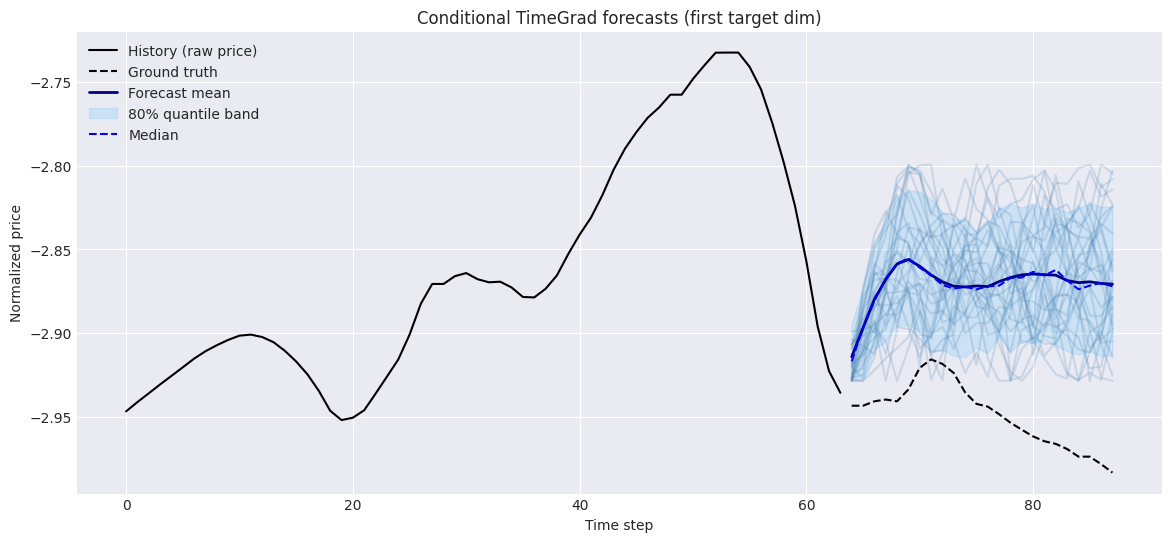

In [10]:
# Plot results for the first series
b = 0
history = x_hist[b].cpu()
ground_truth = first_batch_target[b].cpu()
mean_b = mean_forecast[b].cpu()
q10, q50, q90 = (q[b].cpu() for q in quantiles)

# pick a few sample paths to visualize
sample_paths = samples[:, b].cpu().numpy()
num_plot_paths = min(30, sample_paths.shape[0])

fig, ax = plt.subplots(figsize=(14, 6))

hist_range = range(context_length)
forecast_range = range(context_length, context_length + prediction_length)

target_series = history[:, 0].numpy()
ax.plot(hist_range, target_series, label='History (raw price)', color='black')
ax.plot(forecast_range, ground_truth[:, 0].numpy(), label='Ground truth', color='black', linestyle='--')

for i in range(num_plot_paths):
    ax.plot(forecast_range, sample_paths[i, :, 0], color='steelblue', alpha=0.2)

ax.plot(forecast_range, mean_b[:, 0].numpy(), label='Forecast mean', color='navy', linewidth=2)
ax.fill_between(forecast_range, q10[:, 0].numpy(), q90[:, 0].numpy(), color='lightskyblue', alpha=0.3, label='80% quantile band')
ax.plot(forecast_range, q50[:, 0].numpy(), color='blue', linestyle='--', label='Median')

ax.set_xlabel('Time step')
ax.set_ylabel('Normalized price')
ax.legend(loc='upper left')
ax.set_title('Conditional TimeGrad forecasts (first target dim)')
plt.show()


### Conditioning effects

- The history encoder tokens flow into the cross-attention and FiLM layers, so regime shifts
  (captured in static conditioning) expand the forecast quantile band when volatility rises.
- Dynamic daily/monthly macro signals enter as causal tokens; when they spike, you should observe
  broader scenario dispersion and higher predicted variance.
- The relative positional bias and causal masks keep the autoregressive sampling aligned so
  conditioning only influences future steps through the observed history window.
